Finding optimal frequency:
 - Estimated peak width = 1.26
 - Using 5 steps per peak; omega_step = 0.251
 - User-specified period range:  1.3 to 1.5
 - Computing periods at 4 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
1.59579610803
[ 2457572.9161691   2457574.91549491  2457575.92083924  2457575.90865498
  2457574.88419306  2457576.83806759  2458007.59730312  2457576.85371725
  2458007.79070106  2457572.88485035  2457574.93114456  2457572.90050694
  2457574.89984387  2457576.86937836  2457572.93194711] [ 0.45371236  0.48715334  0.46468489  0.44004161  0.48577633  0.49020284
  0.45984055  0.48922504  0.49964927  0.45087693  0.48530866  0.46081984
  0.48380479  0.48485016  0.44589552] [ 0.01914003  0.02047745  0.0199565   0.01888648  0.02036504  0.02055287
  0.01980655  0.02046481  0.02181425  0.01904357  0.02045922  0.01952345
  0.02028973  0.02032715  0.01874026]


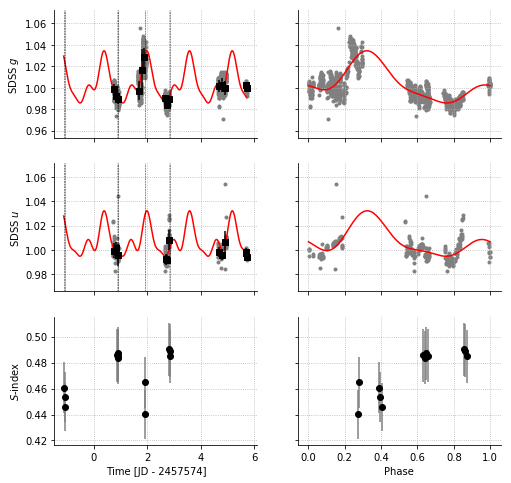

In [5]:
%matplotlib inline

import h5py
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
paths = glob('/Users/bmmorris/data/freckles/*.fits')
from astropy.io import fits
spectrum_times = [fits.getheader(p)['JD'] for p in paths]

times_g, lc_g = np.loadtxt('lc.txt', unpack=True)
times_u, lc_u = np.loadtxt('lc_u.txt', unpack=True)
err = np.std(lc_g)/2

from gatspy import periodic

# Fit the Lomb-Scargle model
model = periodic.LombScargleMultiband(Nterms_base=3)#, fit_period=False)
model.fit(np.concatenate([times_g, times_u]), np.concatenate([lc_g, lc_u]),
          filts=np.concatenate([np.zeros_like(times_g), np.ones_like(times_u)]))

P_rot = 1.407 # (Nielson 2013)
model.optimizer.period_range = (1.3, 1.5)

# Predict on a regular phase grid
period = model.best_period
tfit = np.linspace(0, period, 1000)
magfit_g = model.predict(tfit, filts=0)
magfit_u = model.predict(tfit, filts=1)

# Plot the results
phase_g = (times_g / period) % 1
phasefit_g = (tfit / period)

# Plot the results
phase_u = (times_u / period) % 1
phasefit_u = (tfit / period)

print(period)

fig, ax = plt.subplots(3, 2, figsize=(8, 8), sharex='col', sharey='row')#, sharex='col')
ax[0, 1].scatter(phase_g, lc_g, marker='.', color='gray')
ax[0, 1].plot(phasefit_g, magfit_g, '-', color='r')
ax[0, 0].set(ylabel="SDSS $g$")
ax[1, 1].scatter(phase_u, lc_u, marker='.', color='gray')
ax[1, 1].plot(phasefit_u, magfit_u, '-', color='r')
ax[2, 1].set(xlabel='Phase')

splits_g = np.argwhere(np.diff(times_g) > 0.1).T[0] + 1
splits_g = np.concatenate([[0], splits_g, [len(lc_g)]])

splits_u = np.argwhere(np.diff(times_u) > 0.1).T[0] + 1
splits_u = np.concatenate([[0], splits_u, [len(lc_u)]])

from scipy.stats import binned_statistic

for i in range(len(splits_g)-1):
    bs_g = binned_statistic(times_g[splits_g[i]:splits_g[i+1]],
                          lc_g[splits_g[i]:splits_g[i+1]], statistic='median',
                          bins=3)
    std_g = binned_statistic(times_g[splits_g[i]:splits_g[i+1]],
                           lc_g[splits_g[i]:splits_g[i+1]], statistic='std',
                           bins=3)

    bin_centers = 0.5*(bs_g.bin_edges[1:] + bs_g.bin_edges[:-1])
    ax[0, 0].errorbar(bin_centers - int(times_g.min()), bs_g.statistic,
                      std_g.statistic, fmt='s', color='k', zorder=100)

for i in range(len(splits_u)-1):
    bs_u = binned_statistic(times_u[splits_u[i]:splits_u[i+1]],
                          lc_u[splits_u[i]:splits_u[i+1]], statistic='median',
                          bins=3)
    std_u = binned_statistic(times_u[splits_u[i]:splits_u[i+1]],
                           lc_u[splits_u[i]:splits_u[i+1]], statistic='std',
                           bins=3)
    bin_centers = 0.5*(bs_u.bin_edges[1:] + bs_u.bin_edges[:-1])

    ax[1, 0].errorbar(bin_centers - int(times_g.min()), bs_u.statistic,
                      std_u.statistic, fmt='s', color='k', zorder=100)

trange = np.linspace(np.min(spectrum_times), times_g.max(), 1000)
ax[0, 0].scatter(times_g - int(times_g.min()), lc_g, marker='.', color='gray')
ax[0, 0].plot(trange - int(times_g.min()), model.predict(trange, filts=0), color='r')


ax[1, 0].scatter(times_u - int(times_u.min()), lc_u, marker='.', color='gray')
ax[1, 0].plot(trange - int(times_g.min()), model.predict(trange, filts=1), color='r')

ax[1, 0].set(ylabel='SDSS $u$')

ax[2, 0].set(xlabel='Time [JD - {0}]'.format(int(times_g.min())), ylabel='$S$-index')

for i in spectrum_times:
    ax[0, 0].axvline(i - int(times_g.min()), ls='--', color='k', alpha=0.5, lw=0.5)
    ax[1, 0].axvline(i - int(times_g.min()), ls='--', color='k', alpha=0.5, lw=0.5)



# Plot s_index measurements

import sys
sys.path.insert(0, '/Users/bmmorris/git/arces_hk')

from toolkit import json_to_stars

stars = json_to_stars('/Users/bmmorris/git/arces_hk/data/freckles/KIC9652680_apo_calibrated.json')

times = np.array([s.time.jd for s in stars])
sinds = np.array([s.s_mwo.value if not hasattr(s.s_mwo.value, '__len__') else np.mean(s.s_mwo.value) for s in stars])
sinds_err = np.array([s.s_mwo.err if not hasattr(s.s_mwo.err, '__len__') else np.std(s.s_mwo.value) for s in stars])
print(times, sinds, sinds_err)

in_time_range = ((times < trange.max()) & (times > trange.min()))

ax[2, 0].errorbar(times[in_time_range] - int(times_g.min()),
                  sinds[in_time_range], sinds_err[in_time_range],
                  fmt='o', color='k', ecolor='gray')

sind_phase = (times / period) % 1

ax[2, 1].errorbar(sind_phase[in_time_range],
                  sinds[in_time_range], sinds_err[in_time_range],
                  fmt='o', color='k', ecolor='gray')

#ax[2, 1].plot(sind_phase[in_time_range], model.predict(times[in_time_range], filts=0))

for axis in fig.axes:
    for j in ['right', 'top']:
        axis.spines[j].set_visible(False)

    axis.grid(ls=':')

fig.savefig('plots/arcsat.pdf', bbox_inches='tight')
plt.show()

In [13]:
typical_flux_err = np.median(std_g.statistic)

[Text(0,0.5,'Flux'), Text(0.5,0,'$S$-index')]

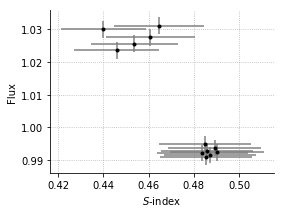

In [19]:
predicted_g_flux = model.predict(times[in_time_range], filts=0)

fig, ax = plt.subplots(figsize=(4, 3))
ax.errorbar(sinds[in_time_range], predicted_g_flux, 
             xerr=sinds_err[in_time_range], yerr=typical_flux_err, 
             fmt='.', color='k', ecolor='gray')

for s in ['right', 'top']: 
    ax.spines[s].set_visible(False)
ax.grid(ls=':')
ax.set(xlabel='$S$-index', ylabel='Flux')

In [86]:
# Stolen from arces_hk/analysis.py

import numpy as np
from scipy.optimize import fmin
import emcee

def v_vector(theta):
    """
    Hogg+ 2010, Eqn 29.
    """
    return [[-np.sin(theta)], [np.cos(theta)]]


def lnprior(p, max_theta=6, min_theta=5):
    theta, b, lnf = p
#     theta, b, = p

    if not ((min_theta < theta < max_theta) and (1 < b < 10000)):
        return -np.inf
    else:
        return 0


def ln_likelihood(p, x, y, x_err, y_err):
    """
    Hogg+ 2010, Eqn 30., with an additional parameter that scales up the
    uncertainty in the x dimension, ``x_err``, by a constant factor.

    The likelihood has been written assuming x and y uncertainties are
    uncorrelated.
    """
#     theta, b, lnf, V = p
    theta, b, lnf = p

#     theta, b = p
    
    v = v_vector(theta)
    f = np.exp(lnf)

    lnp = lnprior(p)
    if not np.isfinite(lnp):
        return lnp

    delta = v[0][0] * x + v[1][0] * y - b * np.cos(theta)
    sigma_sq = v[0][0]**2 * (f * x_err)**2 + v[1][0]**2 * y_err**2
#     sigma_sq = v[0][0]**2 * x_err**2 + v[1][0]**2 * y_err**2
    ln_like = np.sum(-0.5 * (delta**2 / sigma_sq + np.log(sigma_sq) +
                     np.log(2*np.pi)))
    return ln_like


def mcmc_fit(x, y, xerr, yerr, init_guess, nwalkers, n_steps_burnin=1000,
             n_steps_postburnin=2000, ln_likelihood=ln_likelihood):
    ndim = len(init_guess)
    p0 = []

    while len(p0) < nwalkers:
        trial = [init_guess[0] + 0.05 * np.random.randn(),
                 init_guess[1] + 0.01 * np.random.randn(),
                 init_guess[2] + 0.01 * np.random.randn()]
        if np.isfinite(lnprior(trial)):
            p0.append(trial)

    args = (x, y, xerr, yerr)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood, args=args,
                                    threads=8)

    # Burn in for this many steps:
    p1 = sampler.run_mcmc(p0, n_steps_burnin)[0]
    sampler.reset()

    p2 = sampler.run_mcmc(p1, n_steps_burnin)[0]
    sampler.reset()

    # Now run for this many more steps:
    sampler.run_mcmc(p2, n_steps_postburnin)
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
    return samples

In [87]:
samples = mcmc_fit(sinds[in_time_range], predicted_g_flux, 
                   sinds_err[in_time_range], typical_flux_err*np.ones_like(predicted_g_flux),
                   [5.5, 1, 0], 6)

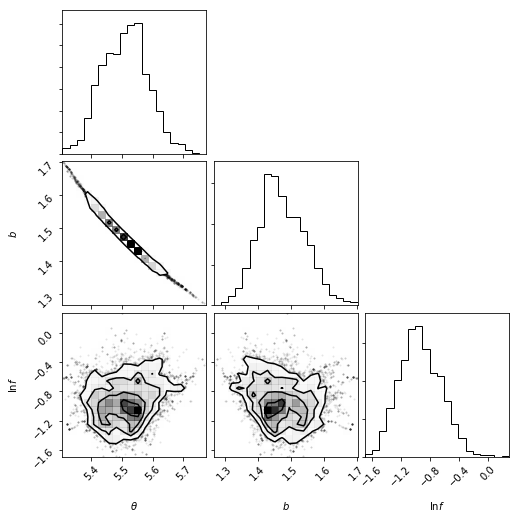

In [88]:
from corner import corner

corner(samples, labels=[r'$\theta$', '$b$', '$\ln f$'])
plt.show()

In [90]:
theta = np.median(samples[:, 0])
b = np.median(samples[:, 1])
lnf = np.median(samples[:, 2])
f = np.exp(lnf)

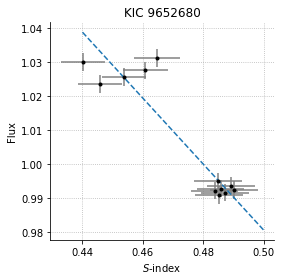

In [94]:
predicted_g_flux = model.predict(times[in_time_range], filts=0)

fig, ax = plt.subplots(figsize=(4, 4))
ax.errorbar(sinds[in_time_range], predicted_g_flux, 
             xerr=f*sinds_err[in_time_range], yerr=typical_flux_err, 
             fmt='.', color='k', ecolor='gray')

xrange = np.linspace(0.44, 0.5)
ax.plot(xrange, b + np.tan(theta) * xrange, ls='--')

for s in ['right', 'top']: 
    ax.spines[s].set_visible(False)
ax.grid(ls=':')
ax.set(xlabel='$S$-index', ylabel='Flux', title='KIC 9652680')
fig.savefig('plots/kic_sindex_vs_flux.pdf', bbox_inches='tight')

In [71]:
print(b, np.tan(theta))

1.34210420708 -0.707605937836
